In [1]:
import pandas as pd
import numpy as np
import seaborn as sns # для визуализации
import matplotlib.pyplot as plt # для визуализации
from sklearn import preprocessing # для стандартизации и нормализации
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif  # anova
import re # для регулярных выражений
from sklearn.model_selection import train_test_split # для разбивки выборок на тренировочную и тестовую
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
import scipy.stats as stats # для стат проверки зависимостей chi2


In [2]:
# из-за длинных наименований и адрес в ноутбуке отобрадается не все содеражимое значений, установим настройку 
pd.set_option('display.max_colwidth', None)

In [3]:
# задаём уровень значимости
alpha = 0.05 

# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

In [4]:
# доп функция для статистической проверки зависимости итогового признака от категориального признака методом хи-квадрат
# вкладываем функцию для принятия решения об отклонении нулевой гипотезы
def chi_2(data, column):
    table = pd.crosstab(data[column], data['reviewer_score'])
    _, p, _, _ = stats.chi2_contingency(table)
    decision_hypothesis(p)

In [5]:
# доп функция для отрисовки графика связи среднего значения рейтинга и значений в целевой колонке
def plot_dep(data, column, plot_ylabel, plot_title):   
    sns.boxplot(y='reviewer_score', x=column, data=data).set(title=plot_title)
    plt.ylabel = plot_ylabel
    plt.xlabel = 'Средняя оценка по рецензии'
    plt.xticks(rotation=45)

In [6]:
# выгружаем данные в 2 df: тренировочный и тестовый 
hotels_train = pd.read_csv('data/hotels_train.csv')
hotels_test = pd.read_csv('data/hotels_test.csv')

In [7]:
# добавим в тестовую выборку целевой признак с 0
hotels_test['reviewer_score'] = 0

In [8]:
# добавим флаг is_train, разделяющий тестовую (0) и тренировочную (1) выборки, 
# это поможет нам потом разделить данные для submission
hotels_train['is_train'] = 1
hotels_test['is_train'] = 0
print('is_train for train {0}, is_train for test {1}'.format(hotels_train['is_train'].unique(), hotels_test['is_train'].unique()))

is_train for train [1], is_train for test [0]


In [9]:
# объединим датафреймы в один
hotels = pd.concat([hotels_train, hotels_test], ignore_index=True)

In [10]:
# посмотрим на статистические показатели по числовым данным
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,is_train
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


Числовые признаки не распределены нормально, так как среднее сильно отличается от медианы, кроме признака average_score. 

In [11]:
# посмотрим на статистические показатели по категориальным данным
hotels.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


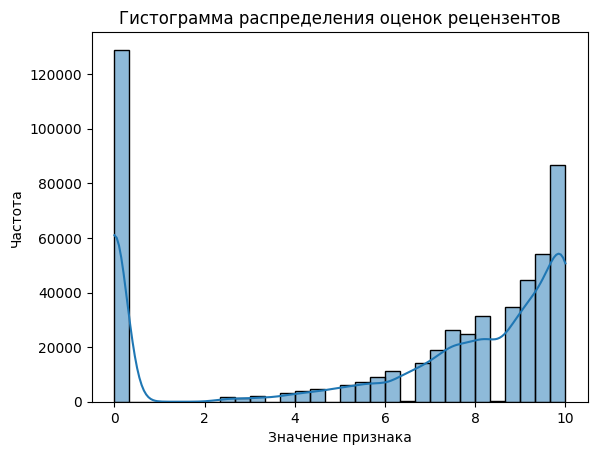

In [12]:
# посмотрим на графическое отображение распределения признака reviewer_score
ax = sns.histplot(hotels['reviewer_score'], bins=30, kde=True)
ax.set(xlabel='Значение признака', ylabel='Частота')
plt.title('Гистограмма распределения оценок рецензентов')

# отображаем гистограмму
plt.show()

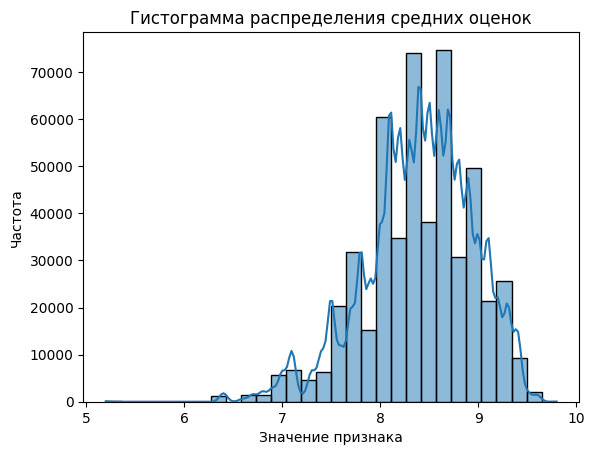

In [13]:
# посмотрим на графическое отображение распределения признака average_score
ax = sns.histplot(hotels['average_score'], bins=30, kde=True)
ax.set(xlabel='Значение признака', ylabel='Частота')
plt.title('Гистограмма распределения средних оценок')

# отображаем гистограмму
plt.show()

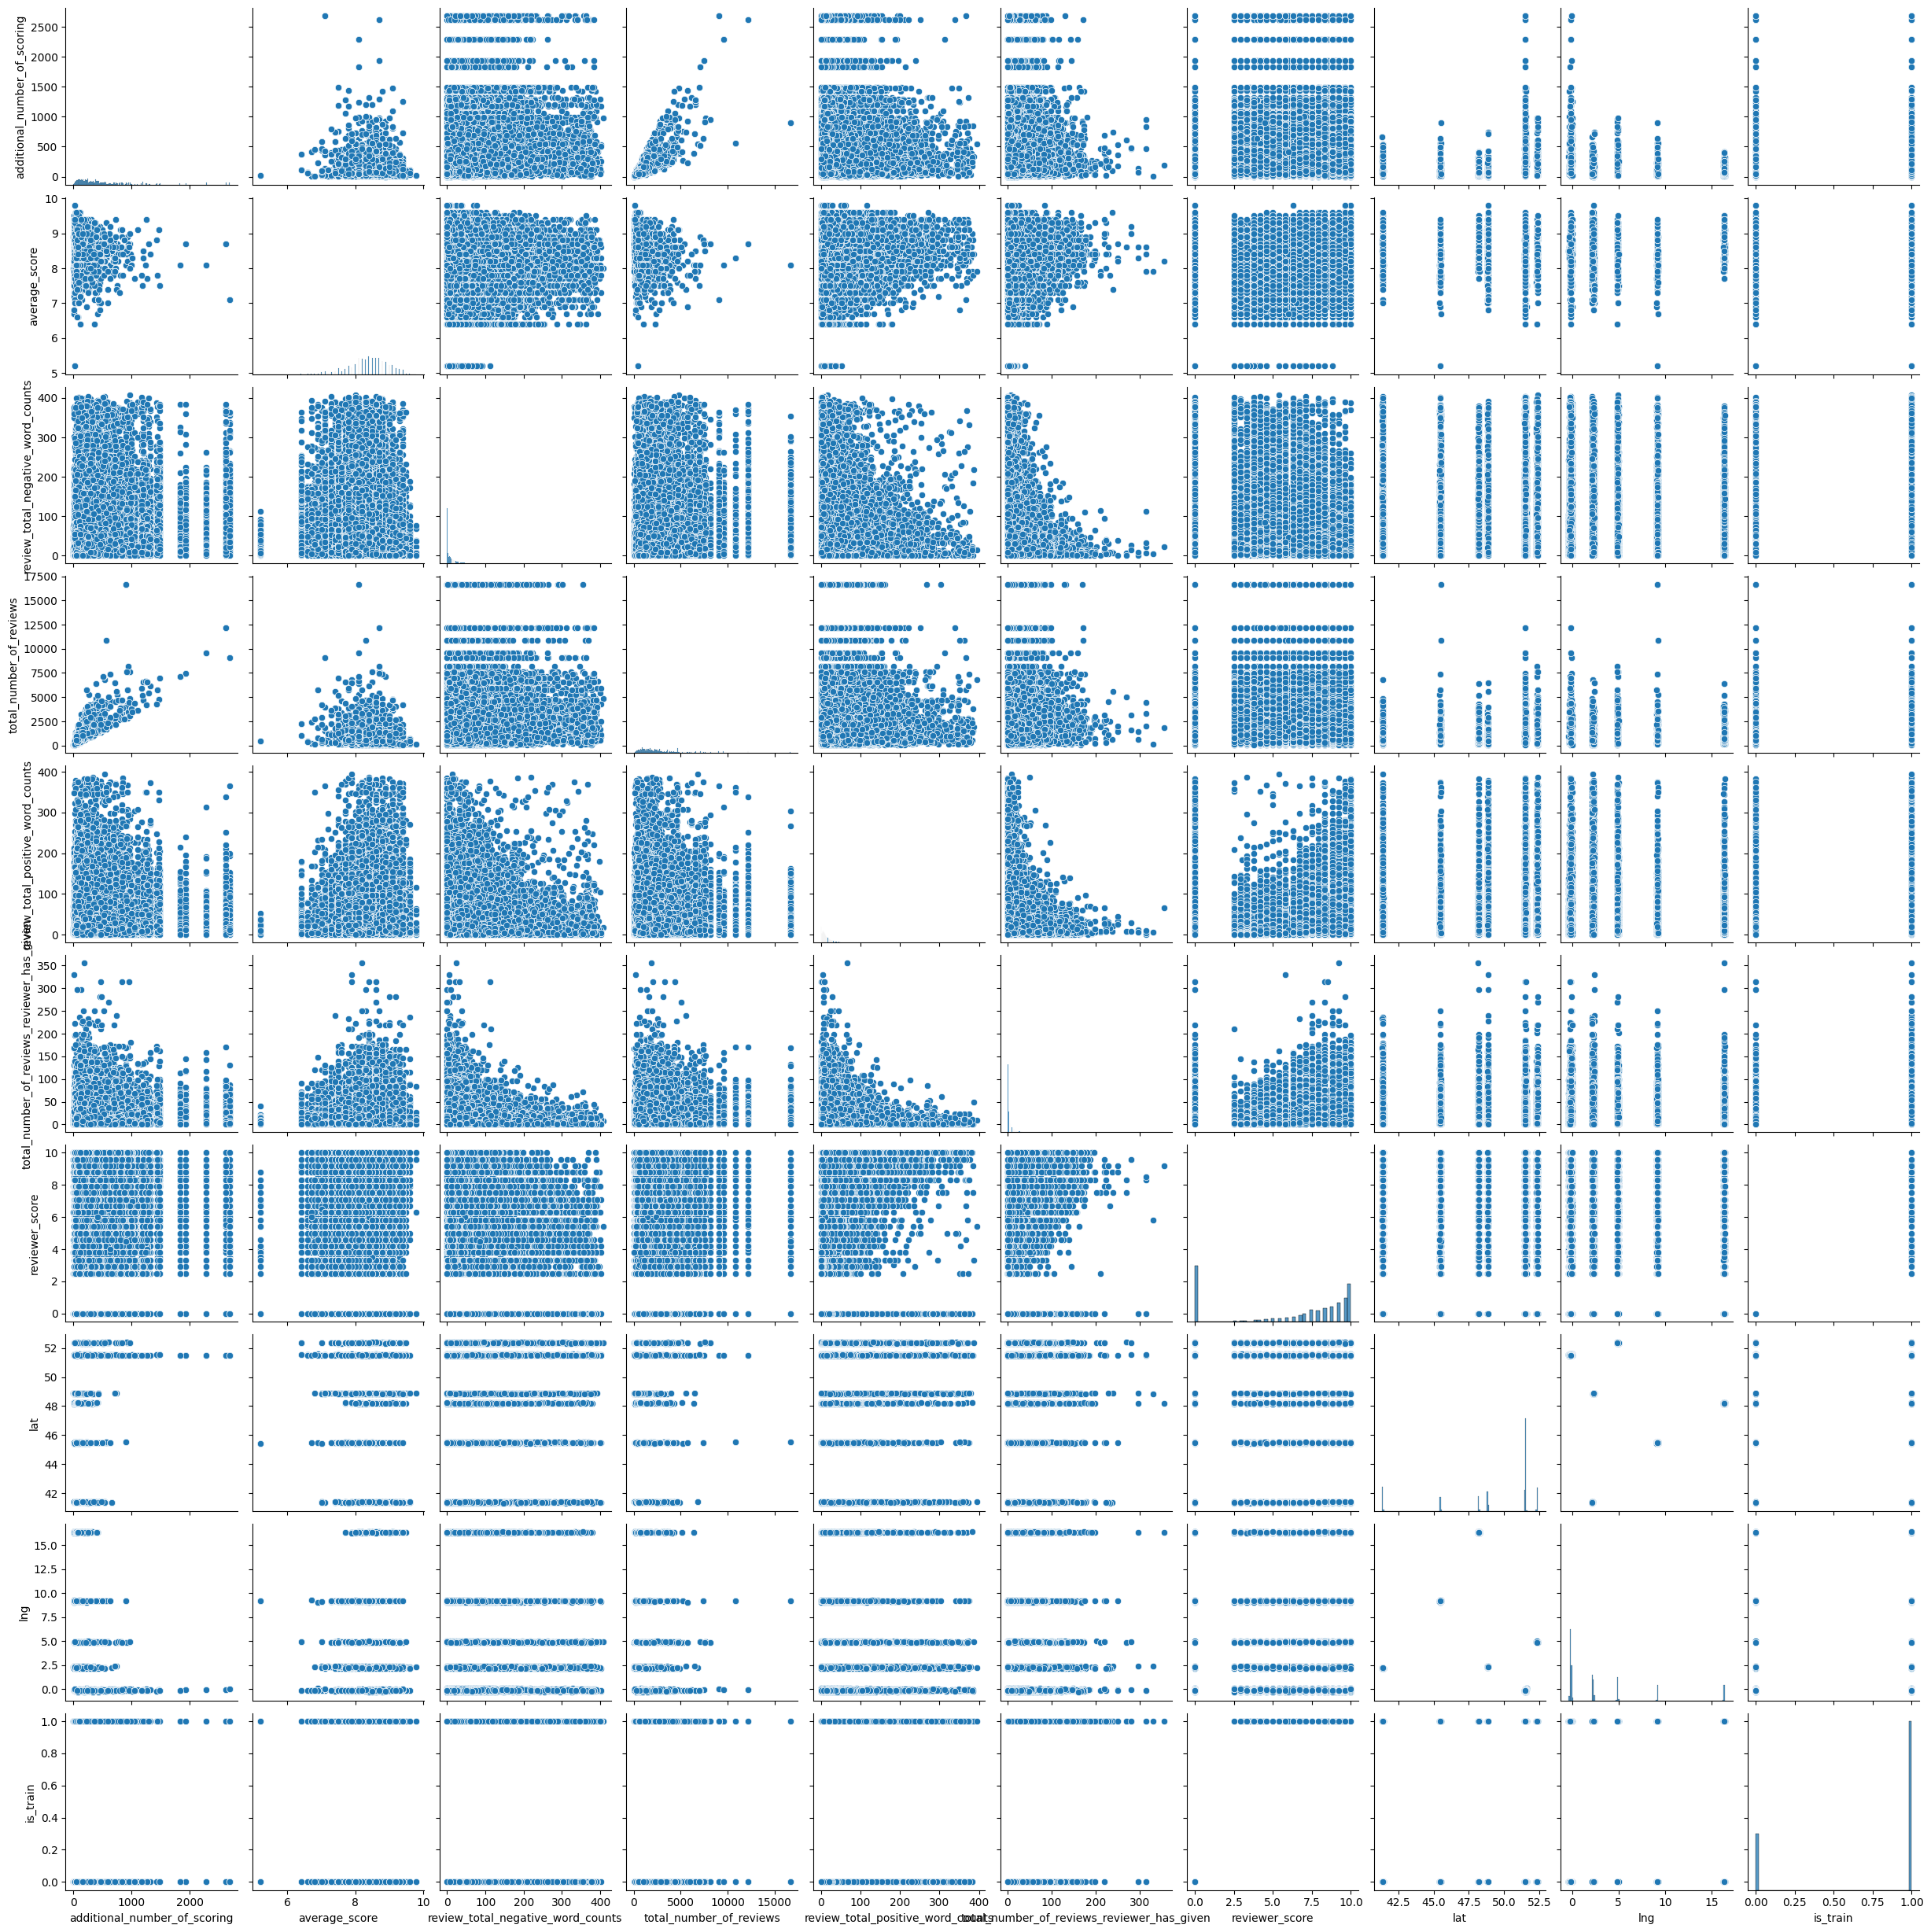

In [14]:
# также можно посмотреть на график попарных отношений 
sns.pairplot(hotels)

Из графика видно, что более менее нормальное распределение имеет только признак average_score, что мы и предположили из статистического анализа. Какой-то наглядной связи между целевым показателем reviewer_score и зависимыми признаками не наблюдается.

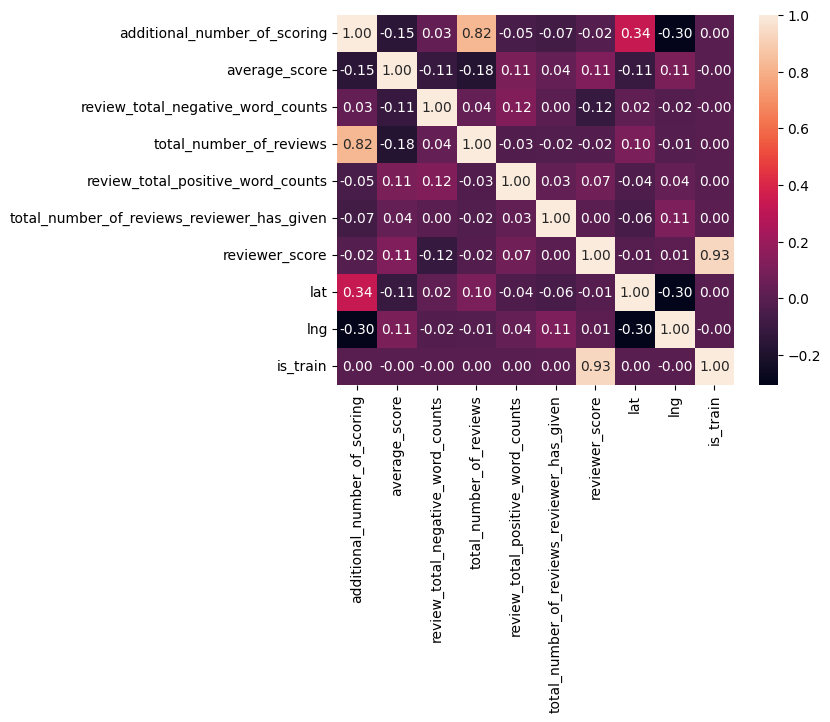

In [15]:
# построим тепловую карту матрицы корреляции
sns.heatmap(hotels.corr(numeric_only=True), annot=True, fmt='.2f');

Как мы и предположили на основании графика попарных отношений наблюдается слабая связь между целеым признаком reviewer_score и зависимыми показателями. Наблюдается сильная связь между 2 признаками: total_number_of_reviews и additional_number_of_scoring, что говорит о мультиколлинеарности. На этапе Отбора признаков один из них удалим из данных.

#### Очистка данных от пропусков

In [16]:
# проверяем наличие пропусков
hotels.isnull().mean().sort_values(ascending=False)

lng                                           0.006337
lat                                           0.006337
hotel_address                                 0.000000
additional_number_of_scoring                  0.000000
days_since_review                             0.000000
tags                                          0.000000
reviewer_score                                0.000000
total_number_of_reviews_reviewer_has_given    0.000000
review_total_positive_word_counts             0.000000
positive_review                               0.000000
total_number_of_reviews                       0.000000
review_total_negative_word_counts             0.000000
negative_review                               0.000000
reviewer_nationality                          0.000000
hotel_name                                    0.000000
average_score                                 0.000000
review_date                                   0.000000
is_train                                      0.000000
dtype: flo

Есть пропуски в 2 столбцах: широта и долгота. Попробуем от них избавиться.

In [17]:
# сформируем df со списком отлей с пустыми координатами
df = hotels.loc[hotels['lat'].isna(), ['hotel_name']]

In [18]:
# посмотрим на уникальный перечень отелей
df.groupby('hotel_name')['hotel_name'].count()

hotel_name
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
City Hotel Deutschmeister                            93
Cordial Theaterhotel Wien                            57
Derag Livinghotel Kaiser Franz Joseph Vienna        147
Fleming s Selection Hotel Wien City                 658
Holiday Inn Paris Montmartre                         55
Hotel Advance                                        28
Hotel Atlanta                                       389
Hotel City Central                                  563
Hotel Daniel Vienna                                 245
Hotel Park Villa                                     61
Hotel Pension Baron am Schottentor                  223
Maison Albar Hotel Paris Op ra Diamond              290
Mercure Paris Gare Montparnasse                      37
NH Collection Barcelona Podium                      146
Renaissance Barcelona Hotel                          33
Roomz Vienna                                         49
Name: hotel_name, dtype: int64

In [19]:
# создадим список отелей, у которых отсутствуют координаты в исходных данных
list_hotels = list(df['hotel_name'].unique())
print(list_hotels)

['Austria Trend Hotel Schloss Wilhelminenberg Wien', 'Holiday Inn Paris Montmartre', 'Fleming s Selection Hotel Wien City', 'Hotel Atlanta', 'Maison Albar Hotel Paris Op ra Diamond', 'Derag Livinghotel Kaiser Franz Joseph Vienna', 'Hotel City Central', 'NH Collection Barcelona Podium', 'City Hotel Deutschmeister', 'Hotel Daniel Vienna', 'Roomz Vienna', 'Hotel Pension Baron am Schottentor', 'Mercure Paris Gare Montparnasse', 'Hotel Park Villa', 'Hotel Advance', 'Renaissance Barcelona Hotel', 'Cordial Theaterhotel Wien']


Есть библиотка geopy, которая позволяет по названиям мест или адресам определять координаты. Попробуем воспользоваться данной библиотекой для устарнения пропусков в наших данных.

In [20]:
# импортируем библиотеку, которая поможет заполнить пропуски в географических координатах
from geopy.geocoders import Nominatim

In [21]:
# тестируем на 1 объекте
geolocator = Nominatim(user_agent="Tester") #Указываем название приложения
adress = str('Austria Trend Hotel Schloss Wilhelminenberg Wien') #Получаем интересующий нас адрес
location = geolocator.geocode(adress)
print(location.latitude, location.longitude)

48.2196753 16.2854959


Отлично! На выходе получаем координаты отеля. Однако при проверке часть наименований отелей не определилась. Поэтому сделаем 4 списка. На первом этапе отберем и найдем координаты отелей, которые опеределяются в функции location(). Далее оставшиеся отели, для которых координаты не нашлись, поищем в интернете и найдем их координаты вручную.

In [22]:
# создаем 2 пустых списка для долготы и широты, а так же 2 списка: 
# список отелей с найденными координатами и список отелей, для которых координат не нашлось
lat = []
lng = []
loc_true = []
loc_non = []

In [23]:
# прогоним по циклу нащ список отелей, найдем координаты 
for hotel in list_hotels:
    location = geolocator.geocode(hotel)
    if location:
        loc_true.append(hotel)
        lat.append(location.latitude)
        lng.append(location.longitude)
    else:
        loc_non.append(hotel)

In [24]:
# у нас осталось 6 отелей без координат, попробуем найти их вручную и добавить в списки координат
loc_non

['Fleming s Selection Hotel Wien City',
 'Maison Albar Hotel Paris Op ra Diamond',
 'Derag Livinghotel Kaiser Franz Joseph Vienna',
 'City Hotel Deutschmeister',
 'Hotel Pension Baron am Schottentor',
 'Mercure Paris Gare Montparnasse']

In [25]:
# создадим новый список с адресами отелей, у которых не определились координаты, адреса которых нашли в интернете
loc_non_adress = ['Josefstädter Straße 10-12, Viena', 
                  '4 Rue de la Pépinière, 75008 Paris',
                  'Sieveringer Str. 4, 1190 Wien', 
                  'Grünentorgasse 30, 1090 Wien',
                  'Währinger Str. 12, 1090 Wien',
                  '20 Rue de la Gaité, 75014 Paris'
                  ]

In [26]:
# прогоним оставшийся список адресов и добавим в основной список
for adrs in loc_non_adress:
    location = geolocator.geocode(adrs)
    loc_true.append(loc_non[loc_non_adress.index(adrs)])
    lat.append(location.latitude)
    lng.append(location.longitude)

In [27]:
# проверим получившиеся списки
print(len(loc_true), loc_true)
print(len(lat), lat)
print(len(lng), lng)

17 ['Austria Trend Hotel Schloss Wilhelminenberg Wien', 'Holiday Inn Paris Montmartre', 'Hotel Atlanta', 'Hotel City Central', 'NH Collection Barcelona Podium', 'Hotel Daniel Vienna', 'Roomz Vienna', 'Hotel Park Villa', 'Hotel Advance', 'Renaissance Barcelona Hotel', 'Cordial Theaterhotel Wien', 'Fleming s Selection Hotel Wien City', 'Maison Albar Hotel Paris Op ra Diamond', 'Derag Livinghotel Kaiser Franz Joseph Vienna', 'City Hotel Deutschmeister', 'Hotel Pension Baron am Schottentor', 'Mercure Paris Gare Montparnasse']
17 [48.2196753, 48.8716034, 50.8520697, 48.2135658, 41.39188235, 48.1888627, 48.222974, 49.13646555, 27.8324526, 41.3927154, 48.20966395, 48.2108117, 48.875248, 48.2516561, 48.2208351, 48.216813, 48.8399395]
17 [16.2854959, 2.3435792, 4.354408380443903, 16.3799212, 2.1779639552623635, 16.3838516356697, 16.393313, 9.230946491810585, 112.9441663, 2.1674921, 16.35142625097432, 16.3422031, 2.3233746, 16.320504901254935, 16.366645, 16.3599356, 2.3236754]


Мы получили все координаты для 17 отелей, у которых были пропуски в исходных данных.

In [28]:
# создадим df с координатами отелей
df_hotels_wo_coord = pd.DataFrame({'hotel_name': loc_true, 'lat': lat, 'lng': lng})
df_hotels_wo_coord

,hotel_name,lat,lng
0,Austria Trend Hotel Schloss Wilhelminenberg Wien,48.219675,16.285496
1,Holiday Inn Paris Montmartre,48.871603,2.343579
2,Hotel Atlanta,50.852070,4.354408
3,Hotel City Central,48.213566,16.379921
4,NH Collection Barcelona Podium,41.391882,2.177964
5,Hotel Daniel Vienna,48.188863,16.383852
6,Roomz Vienna,48.222974,16.393313
7,Hotel Park Villa,49.136466,9.230946
8,Hotel Advance,27.832453,112.944166
9,Renaissance Barcelona Hotel,41.392715,2.167492


In [29]:
# присоединим к основному df новый df с отелями и их координатами
hotels = hotels.merge(
    df_hotels_wo_coord,
    on='hotel_name',
    how='left')

In [30]:
# напишем функцию для проверки столбцов df на NaN для получения итоговых координат из 4 столбцов
def get_coord(x, y):
    if np.isnan(x):
        return y 
    else:
        return x

In [31]:
hotels['lat'] = hotels.apply(lambda row: get_coord(row['lat_x'], row['lat_y']), axis=1)
hotels['lng'] = hotels.apply(lambda row: get_coord(row['lng_x'], row['lng_y']), axis=1)

In [32]:
# удалим исходные столбцы, оставим только с объедиенными данными
hotels = hotels.drop(['lat_x', 'lat_y', 'lng_x', 'lng_y'], axis=1)

In [33]:
# проверяем df на пропуски повторно
hotels.isna().mean()

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
reviewer_score                                0.0
tags                                          0.0
days_since_review                             0.0
is_train                                      0.0
lat                                           0.0
lng                                           0.0
dtype: float64

Пропусков в данных больше нет, отлично! 

#### Генерация признаков

Из всех данных датафрейма 4 поля представляют интерес для генерации признаков:
- количество дней, прошедших с даты отзыва. Данное поле записано в строком формате "число дней и days", заберем количество дней в числовом формате. Возможно данный признак будет оказывать влияние на рейтинг отеля.
- поля тэгов, это строковые данные, которые содержат в себе доп информацию о типе поездки, количестве дней остановки, количестве отдыхающих, типе номера и с какого устрайства забронирован номер (мобильный телефон или нет);
- дата выставления оценки, забрем из даты год, квартал (сезон), месяц;
- адрес отеля, из адреса можно получить информацию о стране расположения отеля для дальнейшего сравнения с национальностью рецензента. Город здесь является неинформартивым признаком, так как он будет в мультиколлинеарной зависимости со страной.

In [34]:
# переведем формат данных в days_since_review из строки в целое число
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split(' ')[0])
hotels['days_since_review'] = hotels['days_since_review'].astype('int32')

In [35]:
# сформируем маьтрицу корреляции между целевым и новым признаком
hotels[['days_since_review', 'reviewer_score']].corr().round(4)

,days_since_review,reviewer_score
days_since_review,1.0000,0.0003
reviewer_score,0.0003,1.0000


Связь между признаками оказалось очень слабой.

In [36]:
# отберем из поля тэгов информацию о типах отдыха и количестве дней остановки. 
# остальные признаки не несут никакой информативности
hotels['stayed_night'] = hotels['tags'].str.findall(r'[S]\w+\s(\d+)\s\w+').str.get(0)
hotels['stayed_night'] = hotels['stayed_night'].fillna(0)
hotels['stayed_night'] = hotels['stayed_night'].astype('int8')
hotels['stayed_night'].head()

0    2
1    1
2    3
3    1
4    6
Name: stayed_night, dtype: int8

In [37]:
# проверим получившиеся значения в поле stayed_night (количество дней остановки)
hotels['stayed_night'].unique()

array([ 2,  1,  3,  6,  4,  5,  8,  7, 10, 14, 19, 13,  9, 17, 11,  0, 27,
       12, 15, 21, 18, 16, 26, 24, 30, 22, 23, 28, 20, 25, 29, 31],
      dtype=int8)

Все данные в числовом формате, при отсутствии данных заменяем на 0.

In [38]:
# сформируем маьтрицу корреляции между целевым и новым признаком
hotels[['stayed_night', 'reviewer_score']].corr().round(4)

,stayed_night,reviewer_score
stayed_night,1.0000,-0.0053
reviewer_score,-0.0053,1.0000


Связь между признаками оказалось очень слабой.

In [39]:
# отберем из поля тэгов информацию о типах отдыха
hotels['purpose_trip'] = hotels['tags'].str.findall(r'([LB]\w+\s+[t]\w+)').str.get(0)
hotels['purpose_trip'].head()

0     Leisure trip
1    Business trip
2     Leisure trip
3     Leisure trip
4    Business trip
Name: purpose_trip, dtype: object

In [40]:
hotels['purpose_trip'].unique()

array(['Leisure trip', 'Business trip', nan], dtype=object)

В тэгах в поле "Тип отдыха" были пропущенные значения, заменим пропуски на модальное значение по данному полю.

In [41]:
# заменим пропуски на модальное значение по данному полю
hotels['purpose_trip'] = hotels['purpose_trip'].fillna(hotels['purpose_trip'].mode()[0])

In [42]:
# перепроверим значения по данному полю
hotels['purpose_trip'].unique()

array(['Leisure trip', 'Business trip'], dtype=object)

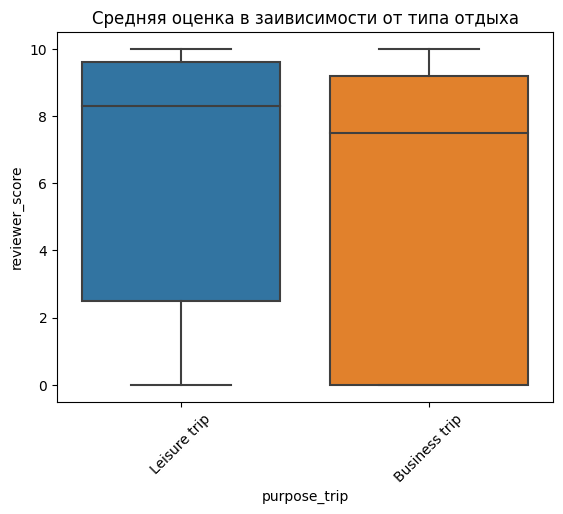

In [43]:
# построим график
plot_dep(hotels, 'purpose_trip', 'Тип отдыха', 'Средняя оценка в заивисимости от типа отдыха')

Данные визуально различны, что говорит о влиянии типа отдыха на оценку. Посмотрим на статестическом тесте.

In [44]:
# нулевая гипотеза: тип отдыха не влияет на среднюю оценку по рецензии 
# альтернативная гипотеза: тип отдыха влияет на среднюю оценку по рецензии 
chi_2(hotels, 'purpose_trip')

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [45]:
hotels = pd.get_dummies(hotels, columns=['purpose_trip'])

In [46]:
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,is_train,lat,lng,stayed_night,purpose_trip_Business trip,purpose_trip_Leisure trip
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531,1,51.507894,-0.143671,2,0,1
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203,1,51.521009,-0.123097,1,1,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289,1,48.845377,2.325643,3,0,1


In [47]:
# ячейка наутбука для тестов регулярных варажений
tst = "[' Leisure trip ', ' Family with young children ', ' Studio Double Family ', ' Stayed 3 nights ', ' Submitted from a mobile device ']"
res = re.findall(r'([S]\w+\s+[f]\w+\s+.\s+[m]\w+)', tst)
res

['Submitted from a mobile']

In [48]:
# отберем из поля тэгов информацию об устройстве бронирования (Submitted from a mobile device)
hotels['submitted_mobile'] = hotels['tags'].str.findall(r'([S]\w+\s+[f]\w+\s+.\s+[m]\w+)').str.get(0)
hotels['submitted_mobile'].unique()

array(['Submitted from a mobile', nan], dtype=object)

In [49]:
# заменим текстовые значения на бинарные (0 и 1)
hotels['submitted_mobile'] = hotels['submitted_mobile'].apply(lambda x: 1 if x == 'Submitted from a mobile' else 0)
hotels['submitted_mobile'].unique()

array([1, 0], dtype=int64)

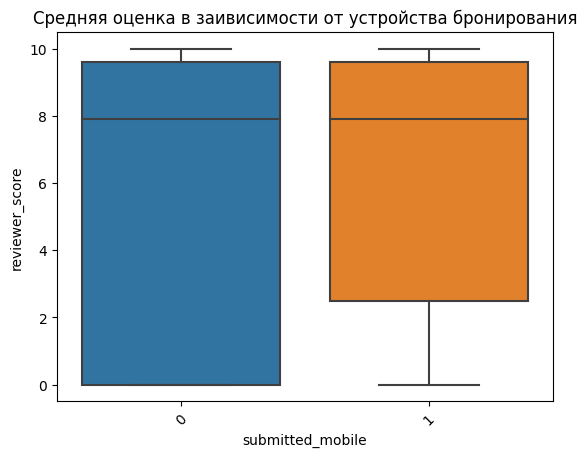

In [50]:
# построим график
plot_dep(hotels, 'submitted_mobile', 'Бронь по телефону', 'Средняя оценка в заивисимости от устройства бронирования')

Графики практиечески идентичные, проверим статистически.  
Нулевая гипотеза: бронирование через телефон или нет не влияет на оценку  
Альтернативная гипотеза: бронирование через телефон влияет на оценку

In [51]:
chi_2(hotels, 'submitted_mobile')

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [52]:
# переведем поле с датой оценки в форматы даты
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

In [53]:
# выделим год, квартал и месяцв отдельные столбцы
hotels['year'] = hotels['review_date'].dt.year
hotels['quarter'] = hotels['review_date'].dt.quarter
hotels['month'] = hotels['review_date'].dt.month
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,is_train,lat,lng,stayed_night,purpose_trip_Business trip,purpose_trip_Leisure trip,submitted_mobile,year,quarter,month
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,1,51.507894,-0.143671,2,0,1,1,2016,1,2
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,1,51.521009,-0.123097,1,1,0,0,2017,1,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,1,48.845377,2.325643,3,0,1,1,2016,4,10
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,...,1,48.888697,2.394540,1,0,1,0,2015,3,9
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,...,1,52.385601,4.847060,6,1,0,0,2016,1,3


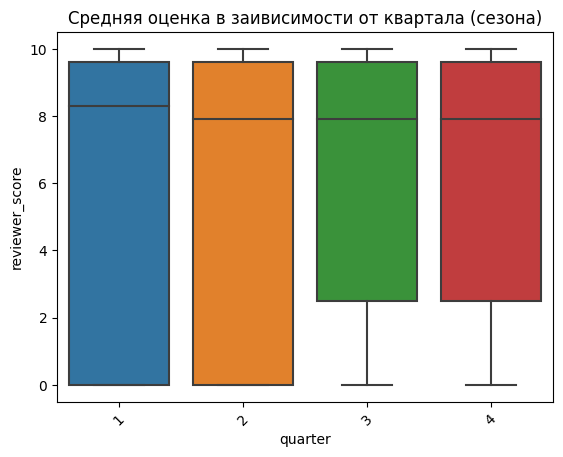

In [54]:
# построим график
plot_dep(hotels, 'quarter', 'Квартал', 'Средняя оценка в заивисимости от квартала (сезона)')

По графику заивисомости видно, что выделяется только 1 квартал, значит от возможно оказывает влияние на целевой показатель. Уровень месяца и года смотреть не имеет смысла из-за небольшой гранулярности по годам и схожсти заивисомости по 2-4 кварталам. 

In [55]:
# добавим признак is_first_q, который будет отражать входит ли месяц в 1 квартал или нет
hotels['is_first_q'] = hotels['quarter'].apply(lambda x: 1 if x == 1 else 0)

In [56]:
# нулевая гипотеза: оценка в 1 квартал не влияет на среднюю оценку по рецензии 
# альтернативная гипотеза: оценка в 1 квартал влияет на среднюю оценку по рецензии 
chi_2(hotels, 'is_first_q')

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Получим из адреса отеля страну нахождения.  
Далее сверим страну нахождения отеля с национальностью рецензента.  
Добавим новое поле is_loc_match со значениями:
- 1 - если страна нахождения отеля и национальность рецензента совпадают;
- 0 - если нет.

In [57]:
hotels['hotel_address'].sample(20)

371119                               Numancia 32 Sants Montju c 08029 Barcelona Spain
176812                         Via Santa Sofia 10 Milan City Center 20122 Milan Italy
432260                             Mallorca 1 23 Sants Montju c 08014 Barcelona Spain
59425     31 Great Cumberland Place Westminster Borough London W1H 7TA United Kingdom
292654       Great Cumberland Place Westminster Borough London W1H 7DL United Kingdom
294772               284 To 302 Waterloo Road Southwark London SE1 8RQ United Kingdom
431206                           Via Spallanzani 40 Central Station 20129 Milan Italy
177969            350 Oxford Street Westminster Borough London W1C 1BY United Kingdom
325208     18 Avenue De Suffren Entr e au 22 rue Jean Rey 15th arr 75015 Paris France
5115                            6 Hercules Road Lambeth London SE1 7DP United Kingdom
503902         27 Devonshire Terrace Westminster Borough London W2 3DP United Kingdom
469230         Weteringschans 251 Amsterdam City Cente

Обратим внимание, что на примере страна предствлена в либо 1 словом, либо 2 в случае если это Соединенное Королевство. Этот момент необходимо будет учесть в заборе данных.

In [58]:
hotel_address_list = hotels['hotel_address'].str.split(' ')
hotel_address_list

0         [Stratton, Street, Mayfair, Westminster, Borough, London, W1J, 8LT, United, Kingdom]
1                     [130, 134, Southampton, Row, Camden, London, WC1B, 5AF, United, Kingdom]
2                                  [151, bis, Rue, de, Rennes, 6th, arr, 75006, Paris, France]
3                                 [216, Avenue, Jean, Jaures, 19th, arr, 75019, Paris, France]
4                                             [Molenwerf, 1, 1014, AG, Amsterdam, Netherlands]
                                                  ...                                         
515733                       [Viale, Monza, 132, Distretto, Viale, Monza, 20127, Milan, Italy]
515734                        [Duc, De, Medinaceli, 8, Ciutat, Vella, 08002, Barcelona, Spain]
515735                          [Wiedner, Hauptstra, e, 44, 04, Wieden, 1040, Vienna, Austria]
515736                         [Corso, Concordia, 1, Milan, City, Center, 20129, Milan, Italy]
515737                                  [202, rue,

In [59]:
hotels['country_hotel'] = hotel_address_list.apply(
    lambda x: x[-1] if x[-1] != 'Kingdom' else 'United Kingdom')
hotels['country_hotel'].unique()

array(['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria',
       'Spain'], dtype=object)

In [60]:
# подсчитаем количество отелей по странам
df_pie = hotels.groupby(['country_hotel'])['country_hotel'].count().sort_values(ascending=False)
df_pie

country_hotel
United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country_hotel, dtype: int64

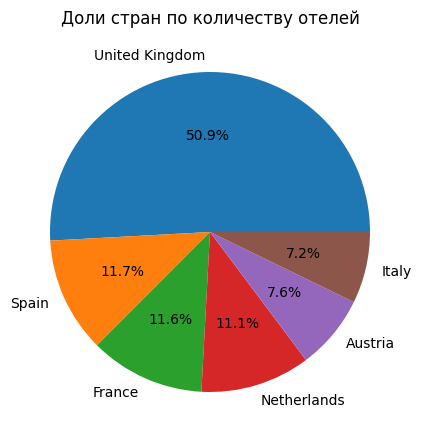

In [61]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes((1, 1, 1, 1))

pie = ax.pie(
    df_pie,
    labels=df_pie.index,
    autopct='%1.1f%%'
)
title = ax.set_title('Доли стран по количеству отелей', fontsize=12)
plt.show(pie);

In [62]:
# проведем сверку страны нахождения отеля и национальности рецензента, добавим признак is_loc_match
hotels['is_loc_match'] = hotels.apply(lambda x: 1 if x['country_hotel'] == str(x['reviewer_nationality']).strip() else 0, axis=1)
hotels['is_loc_match'].unique()

array([1, 0], dtype=int64)

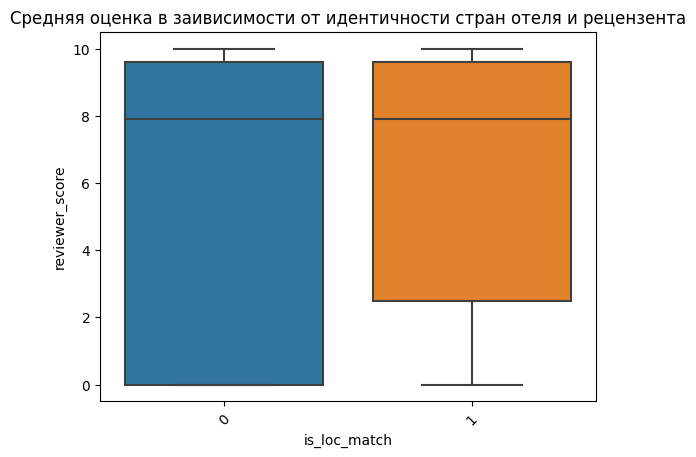

In [63]:
# построим график
plot_dep(hotels, 'is_loc_match', 'Идентичность стран отеля и рецензента', 'Средняя оценка в заивисимости от идентичности стран отеля и рецензента')

Графики практиечески идентичные, проверим статистически.  
Нулевая гипотеза: идентичность страны отеля и рецензента не влияет на оценку  
Альтернативная гипотеза: идентичность страны отеля и рецензента влияет на оценку

In [64]:
chi_2(hotels, 'is_loc_match')

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Отбор признаков

Отберем НЕ информативные признаки, которые не будем подавать в модель, среди них:
- адрес отеля;
- наименование отеля;
- текст позитивного и негативного отзыва, так как у нас есть столбцы с количеством слов позитивных/негативных отзывов;
- дата отзыва, так как у нас есть поле с количеством дней, прошедших с момента отзыва.
- тэги, так как мы сгенерировали из него нужные нам признаки;
- additional_number_of_scoring, так как данный признак нахоится в мультиколлинеарности с признаком total_number_of_reviews.

In [65]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X_var_1 = hotels[['average_score', 
            'review_total_negative_word_counts', 
            'total_number_of_reviews', 
            'review_total_positive_word_counts',
            'lat',
            'lng',
            'stayed_night',
            'purpose_trip_Business trip',
            'purpose_trip_Leisure trip',
            'submitted_mobile',
            'is_first_q',
            'is_loc_match']]
y = hotels['reviewer_score']

In [66]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 
            'review_total_negative_word_counts', 
            'review_total_positive_word_counts',
            'stayed_night',
            ]

# категориальные признаки
cat_cols = ['average_score', 
            'lat', 
            #'lng', 
            'purpose_trip_Business trip',
            'purpose_trip_Leisure trip',
            'submitted_mobile',
            'is_first_q',
            'is_loc_match']

In [67]:
y_int=y.astype('int')

<AxesSubplot: >

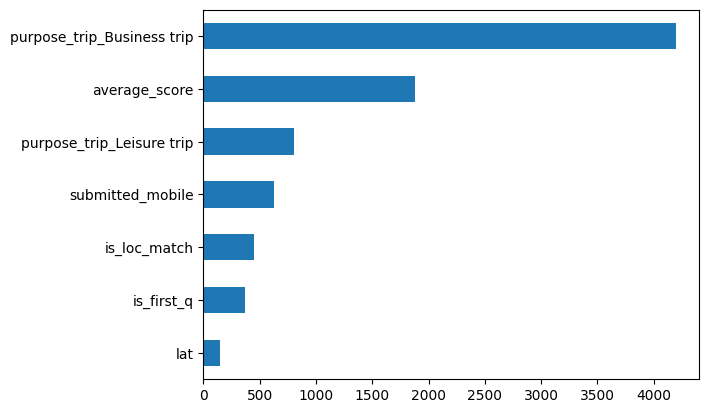

In [68]:
# построим график важности категориальных переменных
imp_cat = pd.Series(chi2(X_var_1[cat_cols], y_int)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

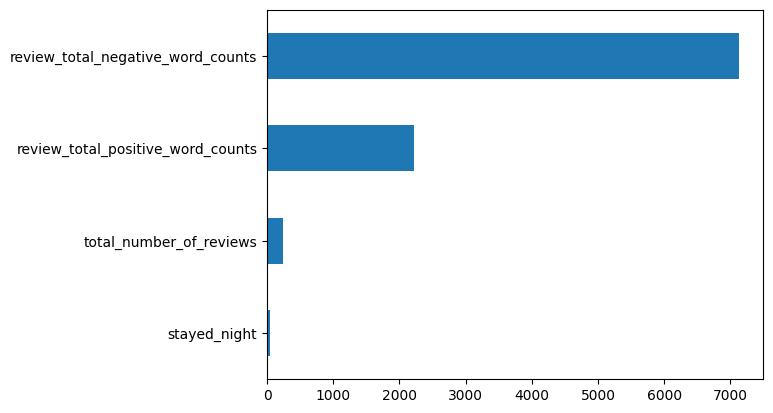

In [69]:
# построим график важности непрерывных переменных
imp_num = pd.Series(f_classif(X_var_1[num_cols], y_int)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

#### Преобразование признаков

In [70]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
data_train = hotels[hotels['is_train'] == 1].drop(['reviewer_score', 'is_train'], axis=1)
data_test = hotels[hotels['is_train'] == 0].drop(['reviewer_score', 'is_train'], axis=1)

X = data_train[X_var_1.columns.to_list()]
y = hotels[hotels['is_train'] == 1]['reviewer_score']

In [71]:
# отберем нужные признаки для тестовых данных
data_test_new = data_test[X_var_1.columns.to_list()]

In [72]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 20% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# проведем стандартизацю признаков в виду разной размерности данных
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
# трансформируем данных в тренировочной и тестовой выборках
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
# проведем нормализацию признаков в виду отсутствия нормального распределения признаков
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_min_max_scaler = min_max_scaler.transform(X_train)
X_test_min_max_scaler = min_max_scaler.transform(X_test)

#### Обучение модели и оценка результатов по MAPE

In [75]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train_scaled, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test_scaled)  

In [76]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', round(metrics.mean_absolute_percentage_error(y_test, y_pred), 4))

MAPE: 0.1391


In [77]:
# Создаём модель  
regr_mm = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr_mm.fit(X_train_min_max_scaler, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred_mm = regr_mm.predict(X_test_min_max_scaler)  

In [78]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', round(metrics.mean_absolute_percentage_error(y_test, y_pred_mm), 4))

MAPE: 0.1394


Обе модели получились примерно динаковые. Итоговое значение MAPE получилось 0.1392.

In [79]:
# проведем стандартизацию тестовых данных
data_test_new_scaled = scaler.transform(data_test_new)

In [80]:
# сделаем предсказание тестовых данных
y_test_pred = regr_mm.predict(data_test_new_scaled)  

In [81]:
y_test_pred.shape

(128935,)

In [82]:
hotels_test.shape

(128935, 18)

In [85]:
submission = pd.read_csv('data/submission.csv')
submission.shape

(128935, 2)

In [86]:
# запишем наши предсказания в файл submission
submission['reviewer_score'] = y_test_pred
submission.sample(10)

,reviewer_score,id
80279,6.078000,512469
2582,6.429000,398920
41314,6.656000,486239
119537,8.747000,404052
52379,8.786000,148824
41487,7.685000,122564
119128,6.940000,327685
78819,9.158000,188160
4403,7.335033,302071
127140,6.758833,261521


In [87]:
submission.to_csv('data/submission_prediction.csv', index=False)

#### Ответим на вопросы по заданию

In [88]:
# сколько уникальных названий отелей представлено в наборе данных?
hotels['hotel_name'].nunique()

1492

In [90]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [91]:
# переведем столбец review_date в формат даты
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

In [92]:
# когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
hotels['review_date'].max()

Timestamp('2017-08-03 00:00:00')

In [93]:
# когда был оставлен самый первый отзыв? Введите ответ в формате yyyy-mm-dd.
hotels['review_date'].min()

Timestamp('2015-08-04 00:00:00')

In [94]:
# сколько уникальных тегов представлено в наборе данных?

In [95]:
# передадим в список все значения поля Тэги
tags_list = list(hotels['tags'])

In [96]:
tags_list

["[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
 "[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",
 "[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",
 "[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",
 "[' Business trip ', ' Solo traveler ', ' Superior Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Double Room Non Smoking ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 4 nights ']",
 "[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']",
 "[' Leisure trip ', ' Couple ', ' Twin Hilton Guest Room ', ' Stayed 1 night ', ' Submitted 

In [97]:
# создадим пустой список для передачи в него всех значений внутри списка списков, 
# так как данные в поле Тэгов передались в виде строки, содержащей список
tags_list_new = []

In [98]:
# сделаем цикл на обработку данных в списке, заменим ненужные символы, разделим строки в списки и почистим лищние пробелы
for i in tags_list:
    i = i.replace('[', '').replace(']', '').replace("'", '')
    z = i.split(',')
    for y in z:
        f = y.strip()
        tags_list_new.append(f)

In [99]:
# создадим множество, содержащее уникальные значения списка тэгов и посчитаем его длину
tags_list_set = set(tags_list_new)
print(len(tags_list_set))

2428


In [100]:
# какой тег представлен в наибольшем числе отзывов?
# импортируем фнукцию Counter из библиотеки collections
from collections import Counter

# создадим счетчик значений в списке tags_list_new и посмотрим наиболее часто повторяющийся тэг
cnt = Counter(tags_list_new)
print(cnt)

Counter({'Leisure trip': 417778, 'Submitted from a mobile device': 307640, 'Couple': 252294, 'Stayed 1 night': 193645, 'Stayed 2 nights': 133937, 'Solo traveler': 108545, 'Stayed 3 nights': 95821, 'Business trip': 82939, 'Group': 65392, 'Family with young children': 61015, 'Stayed 4 nights': 47817, 'Double Room': 35207, 'Standard Double Room': 32248, 'Superior Double Room': 31393, 'Family with older children': 26349, 'Deluxe Double Room': 24823, 'Double or Twin Room': 22393, 'Stayed 5 nights': 20845, 'Standard Double or Twin Room': 17483, 'Classic Double Room': 16989, 'Superior Double or Twin Room': 13570, '2 rooms': 12393, 'Stayed 6 nights': 9776, 'Standard Twin Room': 9745, 'Single Room': 9670, 'Twin Room': 8321, 'Stayed 7 nights': 7399, 'Executive Double Room': 6425, 'Classic Double or Twin Room': 6107, 'Superior Twin Room': 6064, 'Deluxe Double or Twin Room': 5998, 'Club Double Room': 5908, 'Queen Room': 5472, 'Deluxe King Room': 5357, 'Superior Queen Room': 4898, 'Standard Single 

In [101]:
# из тегов выясните, на сколько ночей чаще всего останавливаются путешественники в отелях.
# из предыдущего задания можно посмотреть в каком тэге количество ночей остановки наибольшее
print(cnt)

Counter({'Leisure trip': 417778, 'Submitted from a mobile device': 307640, 'Couple': 252294, 'Stayed 1 night': 193645, 'Stayed 2 nights': 133937, 'Solo traveler': 108545, 'Stayed 3 nights': 95821, 'Business trip': 82939, 'Group': 65392, 'Family with young children': 61015, 'Stayed 4 nights': 47817, 'Double Room': 35207, 'Standard Double Room': 32248, 'Superior Double Room': 31393, 'Family with older children': 26349, 'Deluxe Double Room': 24823, 'Double or Twin Room': 22393, 'Stayed 5 nights': 20845, 'Standard Double or Twin Room': 17483, 'Classic Double Room': 16989, 'Superior Double or Twin Room': 13570, '2 rooms': 12393, 'Stayed 6 nights': 9776, 'Standard Twin Room': 9745, 'Single Room': 9670, 'Twin Room': 8321, 'Stayed 7 nights': 7399, 'Executive Double Room': 6425, 'Classic Double or Twin Room': 6107, 'Superior Twin Room': 6064, 'Deluxe Double or Twin Room': 5998, 'Club Double Room': 5908, 'Queen Room': 5472, 'Deluxe King Room': 5357, 'Superior Queen Room': 4898, 'Standard Single 